Credits:  
[Autoformer](https://github.com/thuml/Autoformer)  
[FEDformer](https://github.com/MAZiqing/FEDformer)  

Keep It Stupd Simple

In [1]:
from types import SimpleNamespace
cfg = {
    # DATA
    'dataset_id':0,
    'step':20, # step input output 
    # 'target_len':20, # same for now

    # MODEL
    'emb_dim':8,
    'c_in':2, # dim of features in
    'c_out':2, # dim out
    'e_layers':2,
    'd_layers':1,
    'dropout':0.0,
    'moving_avg':5,
    
    'n_heads':1,
    
    
    'batch_size':1,


    # 'seq_len':100,
}
cfg = SimpleNamespace(**cfg)

# PART WHERE DATA HAPPENS 

In [38]:
import os
import torch
from tqdm.notebook import tqdm
from scipy.io.wavfile import read
import matplotlib.pyplot as plt


In [3]:
base_paths = [
    '../data/music_data/VBB_DRUM_HITS/VBB_KICKS/',
    '../data/music_data/SOPHIE_sample_library/SOPHIE_one_shots/SOPHIE_drums/SOPHIE_kicks/all_kicks',
    '../data/music_data/Drums/Kicks',
    ]


Challenges:
1. Length of the signal
2. Scale or magnitude of the data 

In [4]:
'''
For each dataset, 
Store mean and std for z-score normalization
'''
mean_std_files = [
    'VBB_KICKS_zmean_zstd.yaml',
    'SOPHIE_zmean_zstd.yaml',
    'Drums_zmean_zstd.yaml'
    ]

z_scale = {}

for i, zs_file in enumerate(mean_std_files):
    z_mean = []
    z_std = []

    path = base_paths[i]
    
    if not os.path.exists(zs_file):
        filenames = os.listdir(path)
        filepaths = [os.path.join(path, fn) for fn in filenames]
        signals = []
        for fp in filepaths: 
            _, signal = read(fp)
            signal = torch.tensor(signal).flatten().float()
            signals += [signal]

        signals = torch.concat(signals, -1)
        z_mean = signals.mean().item()
        z_std = signals.std().item()

        # save values
        with open(zs_file, 'w') as f:
            f.write('z_mean:'+str(z_mean)+'\n')
            f.write('z_std:'+str(z_std))
            
        z_scale[zs_file] = [z_mean, z_std]
    
    # if files already exist
    else:
        with open(zs_file, 'r') as f:
            z_file = f.read()
        
        z_file = z_file.split('\n')
        z_mean = float(z_file[0].split(':')[1])
        z_std = float(z_file[1].split(':')[1])
        # print(z_mean, z_std)
        z_scale[zs_file] = [z_mean, z_std]


In [5]:
z_scale

{'VBB_KICKS_zmean_zstd.yaml': [-561862.3125, 459715136.0],
 'SOPHIE_zmean_zstd.yaml': [30967.67578125, 538729664.0],
 'Drums_zmean_zstd.yaml': [3.824542284011841, 11310.7451171875]}

In [6]:
class Dataset:
    def __init__(self, path, cfg, z_scale):
        filepaths = self._get_filepaths(path)
        self.samples = self._get_samples(filepaths, cfg, z_scale)
        self._len = len(self.samples)

    def __getitem__(self, idx):
        source = self.samples[idx]
        target = source
        return source, target

    def __len__(self):
        return self._len

    def _get_filepaths(self, path):
        filenames = os.listdir(path)

        filepaths = [os.path.join(path, fn) for fn in filenames]
        return filepaths 

    def _get_samples(self, filepaths, cfg, z_scale):
        samples = []
        z_mean = z_scale[0]
        z_std = z_scale[1]

        for path in filepaths:
            _, signal = read(path)
            signal = (torch.tensor(signal) - z_mean) / z_std
            position = torch.arange(signal[:,0].size()[0]).unsqueeze(-1)
            signal = torch.concat((signal, position), -1)

            # Separate signal to samples
            for i in range(0, signal.shape[0]-cfg.step, cfg.step):
                # print(signal.shape[0],i,i+cfg.step)
                samples += [signal[i:i+cfg.step]]
        return samples

In [7]:
ds_path = base_paths[cfg.dataset_id]

key = list(z_scale.keys())[cfg.dataset_id]
ds_z_scale = z_scale[key]

train_ds = Dataset(ds_path, cfg, ds_z_scale)

/tmp/ipykernel_215696/1586169513.py:27: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, signal = read(path)


In [8]:
a,b = train_ds[0]
a.shape, b.shape, len(train_ds)

(torch.Size([20, 3]), torch.Size([20, 3]), 192141)

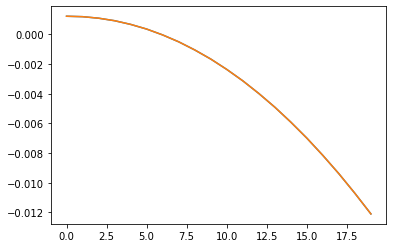

In [9]:
key = list(z_scale.keys())[cfg.dataset_id]

for i in range(1):
    zmean = z_scale[key][0]
    zstd = z_scale[key][1]
    # print(ds[i].shape)
    plt.figure()
    # plt.plot(ds[i])
    # plt.plot((ds[i][0][:,:2] - zmean) / zstd)
    plt.plot(train_ds[i][0][:,:2])
    plt.show()

In [10]:
from torch.utils.data import DataLoader 
train_dl = DataLoader(train_ds, batch_size=64, drop_last=True)

# PART WHERE MODEL HAPPENS 
kinda

In [15]:
source, target = next(iter(train_dl))
position = source[:,:,2]
position.shape

torch.Size([64, 20])

In [16]:
'''
this guy help me to figure out what is going on with positional encodings
https://jamesmccaffrey.wordpress.com/2022/02/09/positional-encoding-for-pytorch-transformer-architecture-models/
'''

class SimplePositionalEncoding:
    def __init__(self, cfg):
        self.pos_emb_dim = cfg.emb_dim
        self.factor = -torch.log(torch.tensor(10000.0)) / self.pos_emb_dim

    def __call__(self, x):
        pos_embedings = []

        for i in range(self.pos_emb_dim):
            div_term = torch.exp(i * self.factor)
            pe = torch.cos(x * div_term).unsqueeze(-1)
            pos_embedings += [pe]
            
        pos_embedings = torch.concat(pos_embedings, -1)

        return pos_embedings

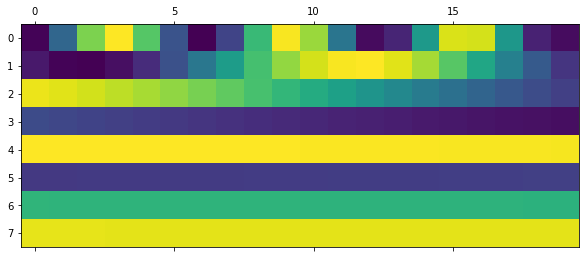

In [29]:
# Just show that positional encoding works as intendet on batched data 
pos_encoding = SimplePositionalEncoding(cfg)
pos_embedings = pos_encoding(position)
plt.matshow(pos_embedings[-1].T)
plt.show()

In [31]:
import torch
import torch.nn as nn
from autocorrelation import *

class SmallerModel(nn.Module):
    '''
    Like autoformer but smaller
    '''
    def __init__(self, cfg):
        super().__init__()

        self.moving_avg = series_decomp(cfg.moving_avg)

        # Projection
        self.pos_encoder = SimplePositionalEncoding(cfg)
        self.src_encoder = TokenEmbedding(cfg.c_in, cfg.emb_dim)

        # Initialize Encoder part
        list_of_encoder_layers = []
        for l in range(cfg.e_layers):
            autocorrelation = AutoCorrelation(
                factor=1, # used for top_k prediction thing
                attention_dropout=cfg.dropout,
                output_attention=True,
                scale=None, # (never used?)
                mask_flag=True # (never used?)
            )

            autocorrelation_layer = AutoCorrelationLayer(
                correlation=autocorrelation,
                d_model=cfg.emb_dim,
                n_heads=cfg.n_heads,
                d_keys=None # Why we not use it? who knows
                ) 
         
            enc_lalyer = EncoderLayer(
                autocorrelation_layer,
                cfg.emb_dim,
                d_ff=None,
                moving_avg=cfg.moving_avg,
                dropout=cfg.dropout,
                activation='gelu'
                )

            list_of_encoder_layers += [enc_lalyer] 

        self.encoder = Encoder(
            list_of_encoder_layers,
            norm_layer=my_Layernorm(cfg.emb_dim)
            )

        # Initialize Decoder part
        list_of_decoder_layers = [] 
        for l in range(cfg.d_layers):
            self_autocorr = AutoCorrelation(
                factor=1, # used for top_k prediction thing
                attention_dropout=cfg.dropout,
                output_attention=False,
                scale=None, # (never used?)
                mask_flag=True, # (never used?)
                )
            self_autocorr_layer = AutoCorrelationLayer(
                correlation=self_autocorr,
                d_model=cfg.emb_dim,
                n_heads=cfg.n_heads,
                d_keys=None
                )
            cross_attention = AutoCorrelation(
                factor=1, # used for top_k prediction thing
                attention_dropout=cfg.dropout,
                output_attention=False,
                scale=None, # (never used?)
                mask_flag=True, # (never used?)
                )

            cross_attention_layer = AutoCorrelationLayer(
                correlation=cross_attention,
                d_model=cfg.emb_dim,
                n_heads=cfg.n_heads,
                d_keys=None
                )

            decoder_layer = DecoderLayer(
                self_attention=self_autocorr_layer, 
                cross_attention=cross_attention_layer, 
                d_model=cfg.emb_dim, 
                c_out=cfg.c_out, 
                d_ff=None,
                moving_avg=cfg.moving_avg, 
                dropout=cfg.dropout, 
                activation="relu"
                )
            
            list_of_decoder_layers += [decoder_layer]
            
        self.decoder = Decoder(
            list_of_decoder_layers,
            norm_layer=my_Layernorm(cfg.emb_dim),
            projection=nn.Linear(cfg.emb_dim, cfg.c_out, bias=True)
            )


    def forward(self, source, target_position, attn_mask=None):
        data = source[:,:,:2]
        position = source[:,:,2]
        # print(position.shape, data.shape)

        # HERE WE USE POWER OF ENCODER !!!
        # encoding position (batch_size, seq_len, )
        # this step is just a projection to a High-dim embedding space,
        # we use special and positional data.
        # How good is this projection who knows.
        pos_enc = self.pos_encoder(position)
        src_enc = self.src_encoder(data) #* math.sqrt(self.emb_dim) # ???
        src_enc = src_enc + pos_enc

        src_enc, corr = self.encoder(src_enc)
        # [64, 20, 8], [64, 20, 1, 8], [64, 20, 1, 8]
        # print(src_enc.shape, corr[0].shape, corr[1].shape)


        # HERE MAKE INTERFACE FOR 2D INTERACTION
        # THIS IS ACTUALLY HARD PART LOL

        # TIME TO GET DECODER TO WORK !!!
        
        # MAGIC TIME
        seasonal_init, trend_init = self.moving_avg(data)
        # [64, 20, 3]
        # plt.figure()
        # plt.plot(data[0], 'r', label='data')
        # plt.plot(seasonal_init[0], 'b', label='seasonal_init')
        # plt.plot(trend_init[0], 'g', label='trend_init')
        # plt.legend()
        # plt.show()
        # print(seasonal_init.shape, trend_init.shape)

        # pos_enc = self.pos_encoder(position)
        # src_enc = self.src_encoder(data) #* math.sqrt(self.emb_dim) # ???
        # src_enc = src_enc + pos_enc

        # 1/0
        # pos_dec, src_enc

        # This thing is decoder input that include, target postion encoding,
        # and seasonal_init... that actually moving avarage of source signal
        pos_dec = self.pos_encoder(target_position)
        src_dec = self.src_encoder(seasonal_init)
        src_dec = src_dec + pos_dec

        seasonal_part, trend_part = self.decoder(
            x=src_dec, 
            cross= src_enc, 
            x_mask=None, 
            cross_mask=None, 
            trend=trend_init)

        # final output blow
        dec_out = seasonal_part + trend_part

        # print(seasonal_part.shape, trend_part.shape)
        return dec_out, corr

model = SmallerModel(cfg)
batch = next(iter(train_dl))
source, target = batch
target_position = target[:,:,2]

# print(source[:,:,:].shape)
out = model(source, target_position)

In [39]:
criterion_mse =  nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), 1e-3)

losses = []
for epoch in tqdm(range(1)):

    for batch in tqdm(train_dl, leave=True):
        source, target = batch
        target_data = target[:,:,:2]
        target_position = target[:,:,2]
        target_data, _ = model(source, target_position)

        loss = criterion_mse(out, target_data)
        loss.backward()
        opt.step()

        losses += [loss.item()]
    #     break
    # break
    print(loss.item())

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3002 [00:00<?, ?it/s]

320.5137939453125


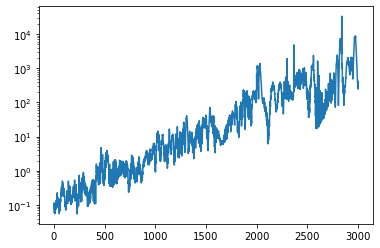

In [53]:
plt.plot(losses)
plt.yscale('log')

In [40]:
out = out.detach().cpu()

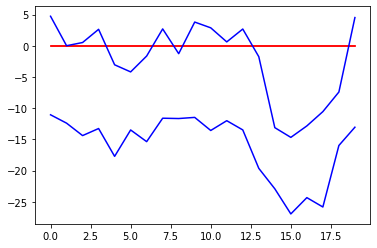

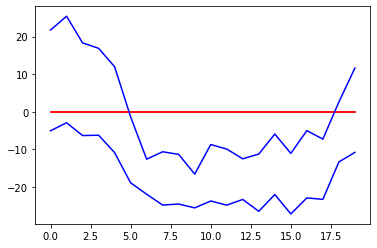

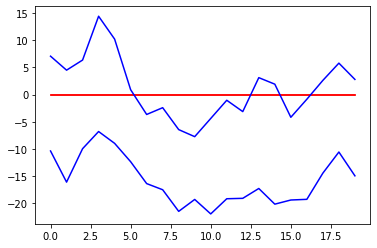

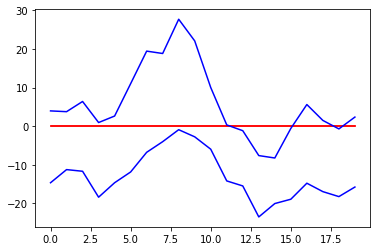

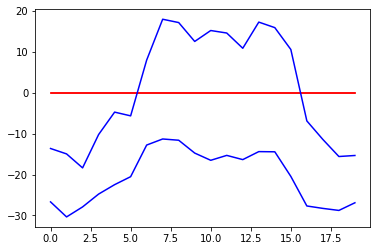

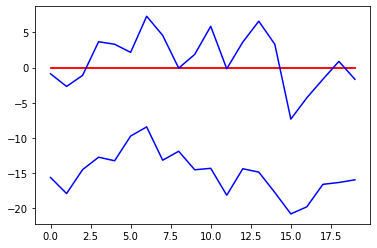

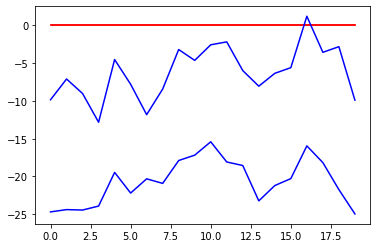

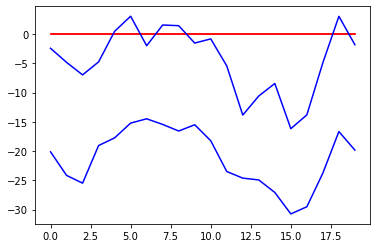

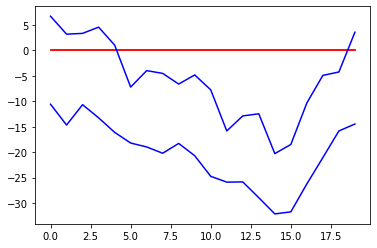

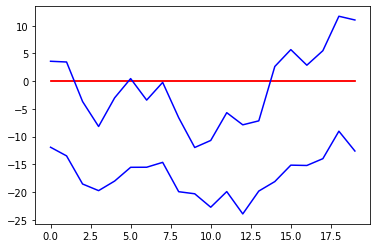

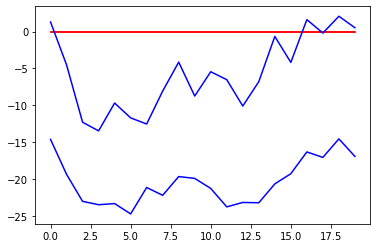

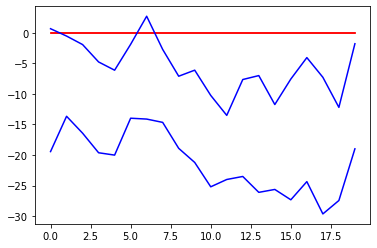

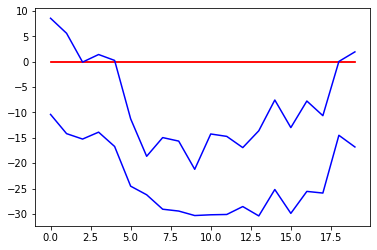

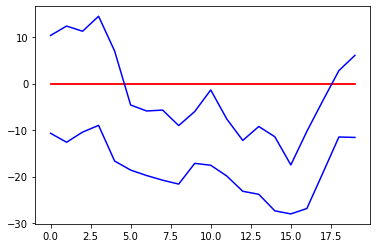

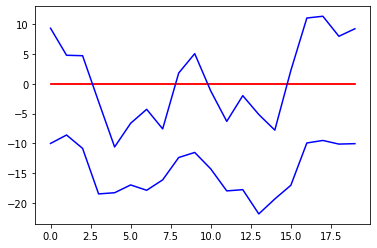

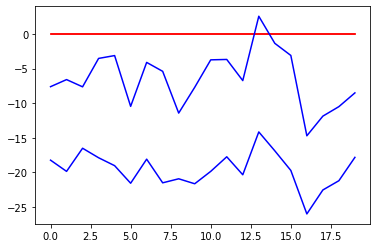

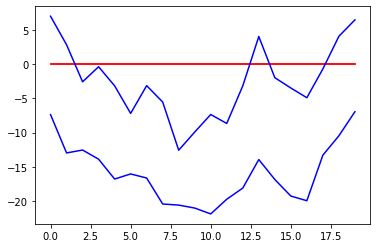

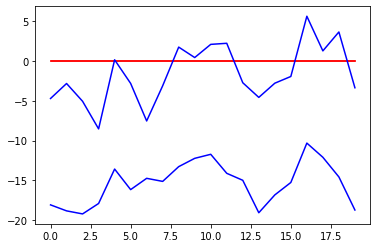

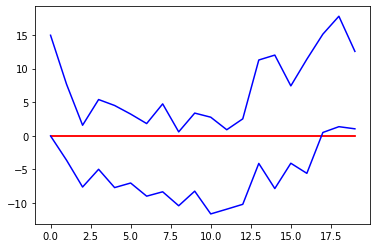

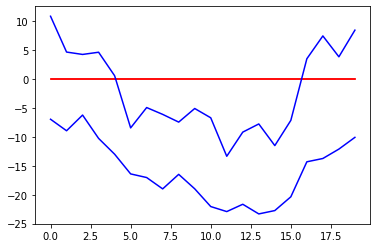

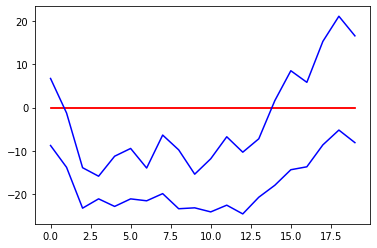

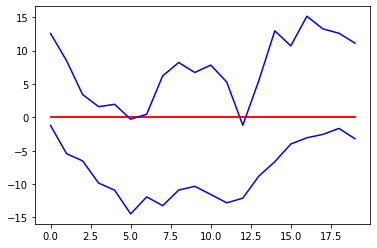

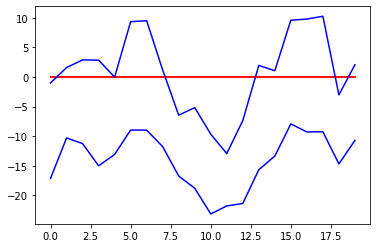

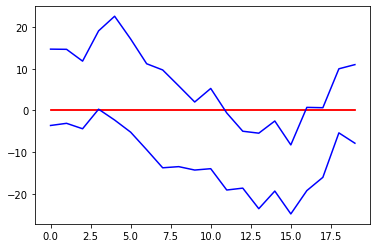

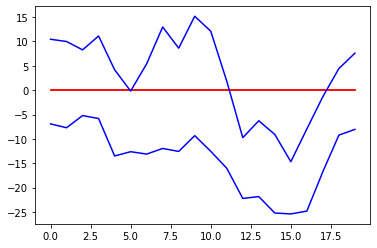

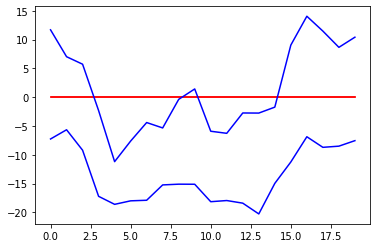

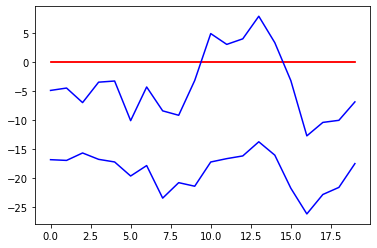

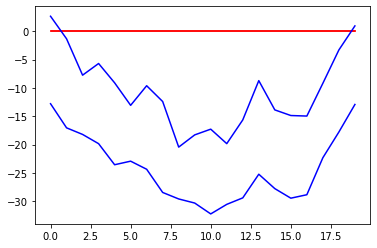

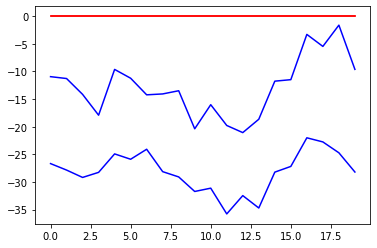

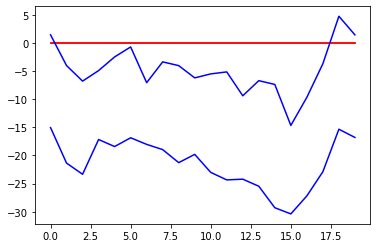

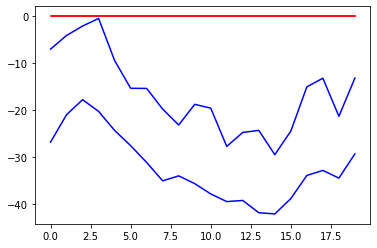

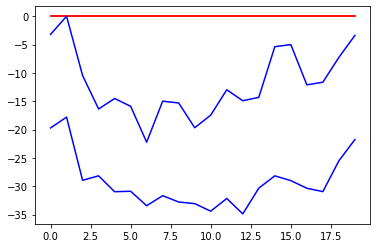

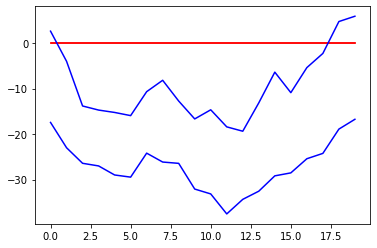

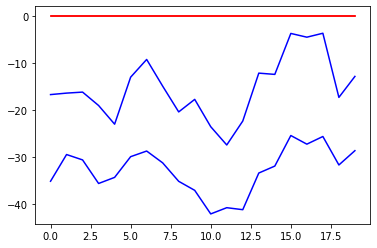

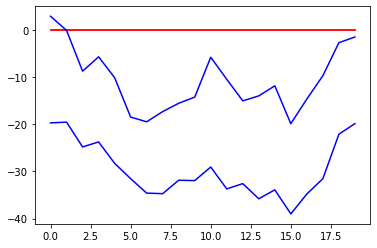

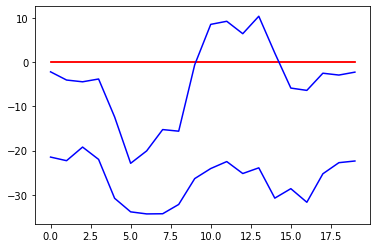

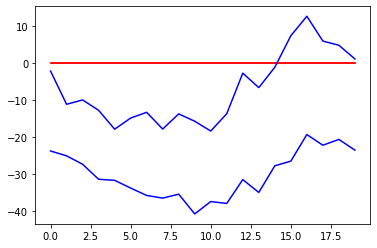

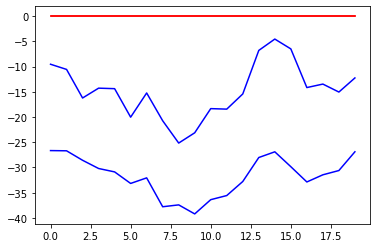

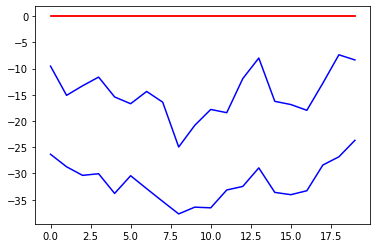

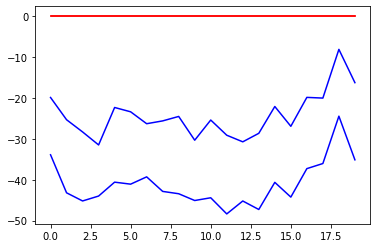

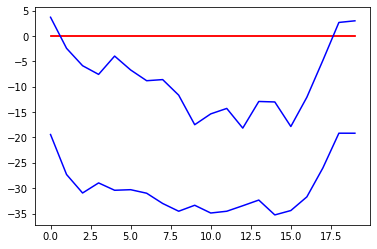

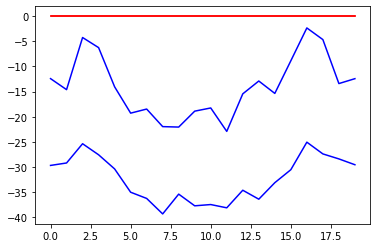

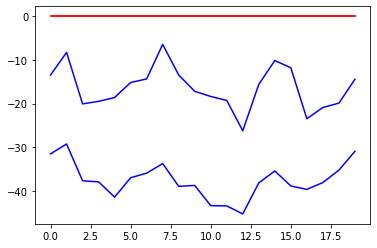

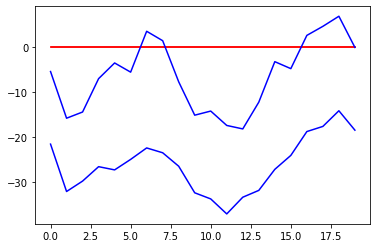

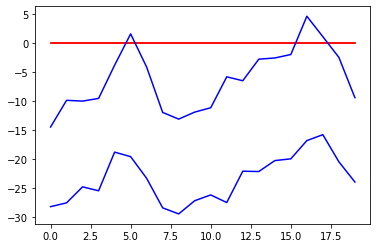

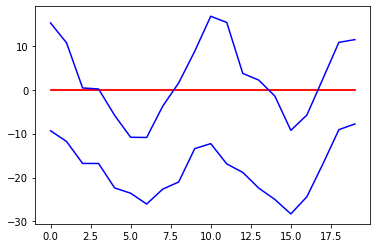

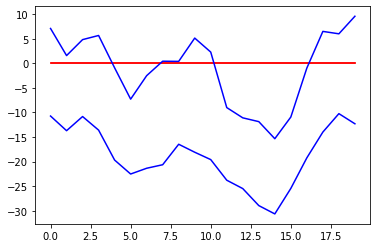

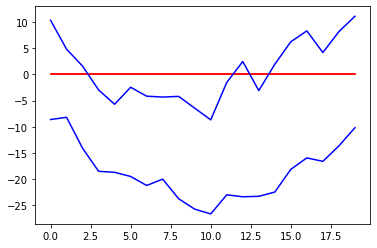

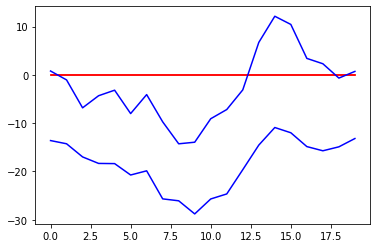

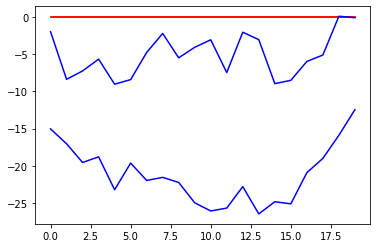

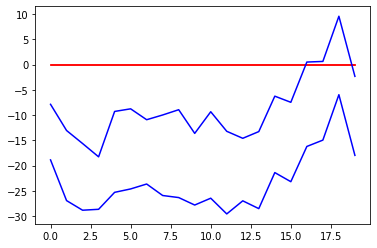

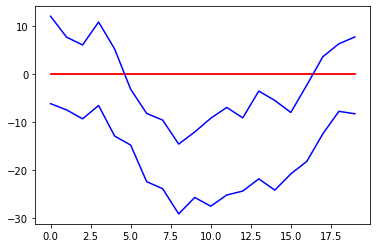

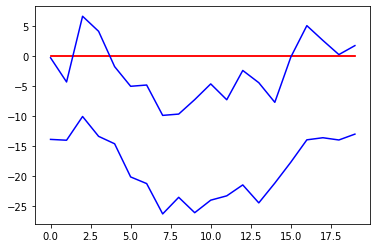

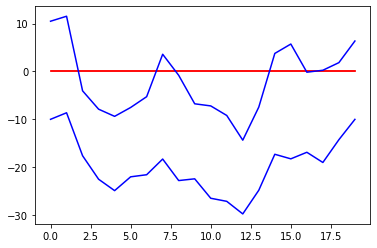

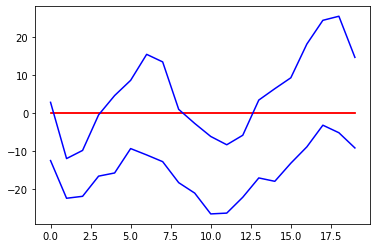

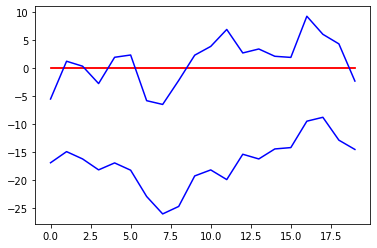

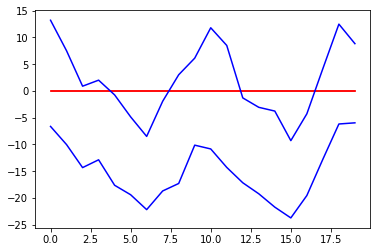

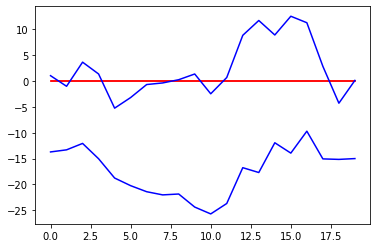

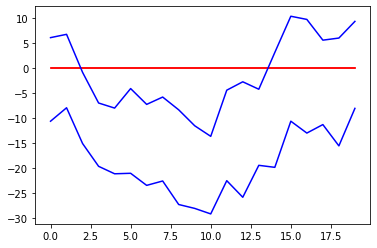

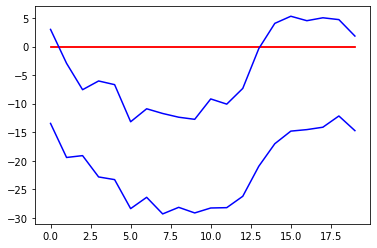

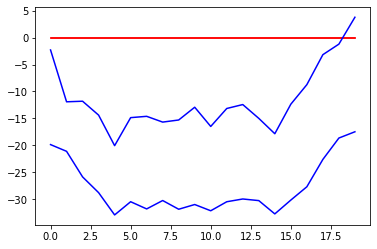

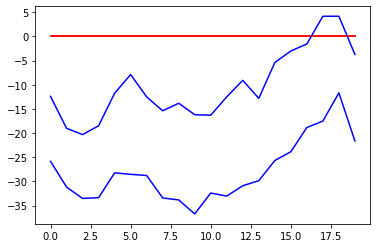

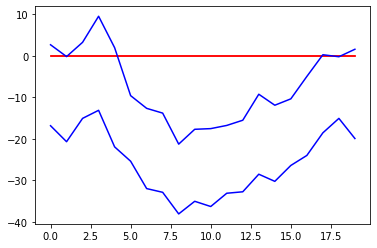

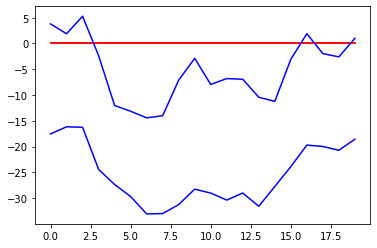

In [51]:
for idx in range(out.shape[0]):
    plt.figure()
    plt.plot(target_data[idx], 'r')
    plt.plot(out[idx], 'b')
    plt.show()
